In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

//miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
user = pandas.read_csv("./dataset/Translation_Test/user_table.csv")

In [3]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [4]:
test = pandas.read_csv("./dataset/Translation_Test/test_table.csv")

In [5]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [6]:
user.shape

(452867, 4)

In [7]:
test.shape

(453321, 9)

In [8]:
test['user_id'].nunique()

453321

In [10]:
user['user_id'].nunique()

452867

In [11]:
# join
data = test.merge(user, on=['user_id'])
  
#make it a date
data["date"]   = pandas.to_datetime(data["date"])

In [13]:
data.describe()

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [14]:
data.describe(include="all")

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
count,452867.000000,452867,452867,452867,452867,181693,452867,452867.000000,452867.000000,452867,452867.000000,452867
unique,NaN,5,3,2,3,5,7,NaN,NaN,2,NaN,17
top,NaN,2015-12-04 00:00:00,Ads,Web,ES,Facebook,Android_App,NaN,NaN,M,NaN,Mexico
freq,NaN,141024,181693,251316,377160,68358,154977,NaN,NaN,264485,NaN,128484
first,NaN,2015-11-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,499944.805166,NaN,NaN,NaN,NaN,NaN,NaN,0.049560,0.476462,NaN,27.130740,NaN
std,288676.264784,NaN,NaN,NaN,NaN,NaN,NaN,0.217034,0.499446,NaN,6.776678,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,18.000000,NaN
25%,249819.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,22.000000,NaN


First question is about checking the test results. But even before that, let’s make sure it is true Spain converts much better than LatAm countries.

In [15]:
country_conversion = data.query('test == 0').groupby('country')['conversion'].mean()
country_conversion.sort_values(ascending=False)

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64

Yes. Definitely true.

In [16]:
#a simple t-test here should work. We have collected ~0.5MM data and test/control split is ~50/50.
from scipy import stats
  
#nothing changed in Spain, so no point in keeping those users
data = data.query('country != "Spain"') 
  
#t-test of test vs control for our target metric 
test = stats.ttest_ind(data[data['test'] == 1]['conversion'], 
                       data[data['test'] == 0]['conversion'], 
                       equal_var=False
                       )
  
print(data.groupby('test')['conversion'].mean())

test
0    0.048292
1    0.043411
Name: conversion, dtype: float64


In [17]:
print(test.statistic)

-7.353895203080277


In [18]:
print(test.pvalue)

1.9289178577799033e-13


Mmh…control users are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. The most likely reason for weird A/B test results are:

1) We didn’t collect enough data

2) Some bias has been introduced in the experiment so that test/control people are not really random


In data science, whenever results appear too bad or too good to be true, they are not true.

Firstly, let’s plot day by day, to see if these weird results have been constantly happening or they just started happening all of a sudden.

In [20]:
import matplotlib.pyplot as plt

data_test_by_day = data.groupby("date")["conversion"].agg({
"test_vs_control": lambda x: x[data["test"]==1].mean()/x[data["test"]==0].mean()
}).plot(),  renaming not working

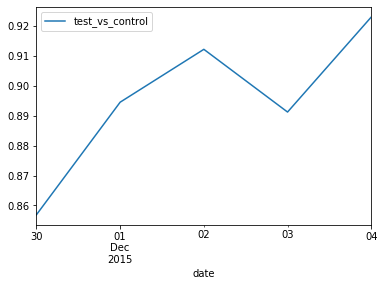

In [27]:
data_test_by_day = data.groupby("date")["conversion"].agg(test_vs_control= lambda x: x[data["test"]==1].mean()/x[data["test"]==0].mean() ).plot()

From the plot, we notice a couple of things:


Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up


As a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better


Time to find out the bias! Likely, there is some segment of users more likely to end up in test or in control. This segment had a significantly above/below conversion rate and this affected the overall results.

# Check A/B Test Randomization

Checking that randomization worked well simply means making sure that all variables have the same distribution in test and control. So, taking for instance the first variable, source, it would mean checking that proportion of users coming from ads, SEO, and direct is the same.


This can easily be done the following way:

In [25]:
#let's group by source and estimate relative frequencies
data_grouped_source = data.groupby("source")["test"].agg(
frequency_test_0 = lambda x: len(x[x==0]), 
frequency_test_1 = lambda x: len(x[x==1])
)

In [26]:
data_grouped_source/data_grouped_source.sum()

,frequency_test_0,frequency_test_1
source,,
Ads,0.401228,0.400641
Direct,0.200949,0.199500
SEO,0.397823,0.399858


As we can see, relative frequency of source for different segments is the same. That is, we have basically the same proportion of users coming from Ads, Direct, and SEO in both test and control.


We could potentially keep checking all the variables like this. But it would be extremely time consuming (and boring), especially when you start considering numerical variables and categorical variables with many levels.


So we turn this into a machine learning problem and let an algorithm do the boring work for us. The approach is:


Get rid of the conversion variable for now. We don’t care about it here. We are just checking if the two user distributions are the same. This is before we check conversion rate for the groups


Use the variable test as our label. Try to build a model that manages to separate the users whose test value is 0 vs those whose test value is 1. If randomization worked well, this will be impossible because the two groups are exactly the same. If all variable relative frequencies were the same as for source, no model would be able to separate test == 1 vs test == 0. If randomization did not work well, the model will manage to use a given variable to separate the two groups.


As a model, pick a decision tree. This will allow you to clearly see which variable (if any) is used for the split. That’s where randomization failed.

In [28]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
#make date as string, so few dates that makes sense to have them as few dummy values  
data['date'] = data['date'].apply(str)
  
#make dummy vars. Don't drop one level here, keep them all. You don't want to risk dropping the one level that actually creates problems with the randomization
data_dummy = pandas.get_dummies(data)
#model features, test is the label and conversion is not needed 
train_cols = data_dummy.drop(['test', 'conversion'], axis=1)
  
tree=DecisionTreeClassifier(
    #change weights. Our data set is now perfectly balanced. It makes easier to understand the tree output
    class_weight="balanced",
    #only split if if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,data_dummy['test'])
  
export_graphviz(tree, out_file="tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_test.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_test.dot")
s.view()

'tree_test.dot.pdf'

So we can see that test and control are not the same! Users from Argentina and Uruguay are way more likely to be in test than control. When country_Argentina is 1, the tree shows that users in control are ~23% and in test 77%. For Uruguay, the proportions are even more extreme: 11% in control and 89% in test! Not good!


Let’s double check this. Let’s check proportion of Argentinian and Uruguayan users in control vs test.

In [29]:
data_dummy.groupby("test")[["country_Argentina", "country_Uruguay"]].mean()

,country_Argentina,country_Uruguay
test,,
0,0.050488,0.002239
1,0.173223,0.017236


Our tree was right! In test, 17% of users are from Argentina, but in control only 5% of users are from Argentina. Uruguay is even more extreme: test has 1.7% of users from Uruguay and control has just 0.2% of Uruguayan users.


And this is a big problem because that means we are not comparing anymore apples to apples in our A/B test. The difference we might see in conversion rate might very well depend on the fact that users between the two groups are different.


Let’s check it in practice:

In [31]:
#this is the test results using the orginal dataset
original_data = stats.ttest_ind(data_dummy[data['test'] == 1]['conversion'], 
                                data_dummy[data['test'] == 0]['conversion'], 
                                equal_var=False)
  
#this is after removing Argentina and Uruguay
data_no_AR_UR = stats.ttest_ind(data_dummy[(data['test'] == 1) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                data_dummy[(data['test'] == 0) & 
                                           (data_dummy['country_Argentina'] ==  0) & 
                                           (data_dummy['country_Uruguay'] ==  0)
                                           ]['conversion'], 
                                equal_var=False)
  
pandas.DataFrame({"data_type" : ["Full", "Removed_Argentina_Uruguay"], 
                  "p_value" : [original_data.pvalue, data_no_AR_UR.pvalue],
                  "t_statistic" : [original_data.statistic, data_no_AR_UR.statistic]
                 })

,data_type,p_value,t_statistic
0,Full,1.928918e-13,-7.353895
1,Removed_Argentina_Uruguay,7.200849e-01,0.358346


Huge difference! The biased test where some countries are over/under represented is statistically significant with negative t statistics. So test is worse than control! After removing those two countries, we get non-significant results.


We can also get to the same conclusion by checking how each country is doing taken by itself:

In [33]:
data_test_country = data.groupby('country')['conversion'].agg(
                   p_value = lambda x: stats.ttest_ind(x[data["test"]==1], 
                                                        x[data["test"]==0], 
                                                        equal_var=False
                                                        ).pvalue,
                   conversion_test = lambda x: x[data["test"]==1].mean(),
                   conversion_control= lambda x: x[data["test"]==0].mean()
                   ).reindex(['p_value','conversion_test','conversion_control'], 
                                   axis=1
                                 )

In [34]:
data_test_country.sort_values(by=['p_value'])

,p_value,conversion_test,conversion_control
country,,,
Mexico,0.165544,0.051186,0.049495
El Salvador,0.248127,0.047947,0.053554
Chile,0.302848,0.051295,0.048107
Argentina,0.335147,0.013725,0.015071
Colombia,0.423719,0.050571,0.052089
Honduras,0.471463,0.047540,0.050906
Guatemala,0.572107,0.048647,0.050643
Venezuela,0.573702,0.048978,0.050344
Costa Rica,0.687876,0.054738,0.052256


After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!


At this point, you have two options:


Acknowledge that there was a bug, go talk to the software engineer in charge of randomization, figure out what went wrong, fix it and re-run the test. Note that when you find a bug, it might be a sign that more things are messed up, not just the one you found. So when you find a bug, always try to get to the bottom of it


If you do find out that everything else was fine, but for some reason there was only a problem with those two countries, you can potentially adjust the weights for those two segments so that relative frequencies become the same and then re-check the test results